In this notebook, I go over the different SAM parameters and illustrate the effects changing each parameter has on the results.

The main parameters of the `run` function (which runs the SAM analysis) are as follows:

- `k` - the number of nearest neighbors to identify for each cell in the graphs constructed by SAM

- `num_norm_avg` - The top 'num_norm_avg' spatial dispersions are averaged to determine the normalization factor when calculating the weights. This prevents genes with extremely large spatial dispersions from skewing the distribution of weights.

- `preprocessing` - Determines whether we 
     - (A) normalize the expression data (prior to SAM weighting and PCA) such that each cell has unit L2 norm OR
     - (B) standardize the expression data (prior to SAM weighting and PCA) such that each gene has zero mean and unit variance. 

There are other parameters, but these are the ones that are most relevant.

In [1]:
from SAM import SAM
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 

sam=SAM()
sam.load_data('../../example_data/schisto2.5_tpm.csv.gz')
sam.preprocess_data()

/home/alec/anaconda3/envs/scrna/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## k 

Here, I vary `k` and show the resulting manifolds with cluster assignments computed on the 'default' manifold (the manifold obtained using default parameters) overlaid.

Intuitively, `k` determines over what lengthscale we average the gene expression values prior to computing spatial dispersions. For example, if `k`=20, each cell averages its gene expressions with its 20 nearest neighbors

RUNNING SAM
Iteration: 0, Convergence: 0.46086124800766526
Iteration: 1, Convergence: 0.1367857448076162
Iteration: 2, Convergence: 0.07075437351179213
Iteration: 3, Convergence: 0.020853998169901154
Iteration: 4, Convergence: 0.007810622477195974
Computing the UMAP embedding...
Elapsed time: 4.811673879623413 seconds


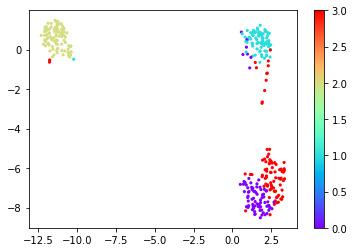

In [2]:
sam.run(k = 20) #default value
sam.clustering(param = 4, method = 'kmeans')
sam.scatter(c = 'kmeans_clusters');

In [3]:
ks = [5,10,20,40,80,120,160,200]
umaps=[]
for k in ks:
    sam.run(k=k,verbose=False)
    xumap = sam.adata.obsm['X_umap']
    umaps.append(xumap)

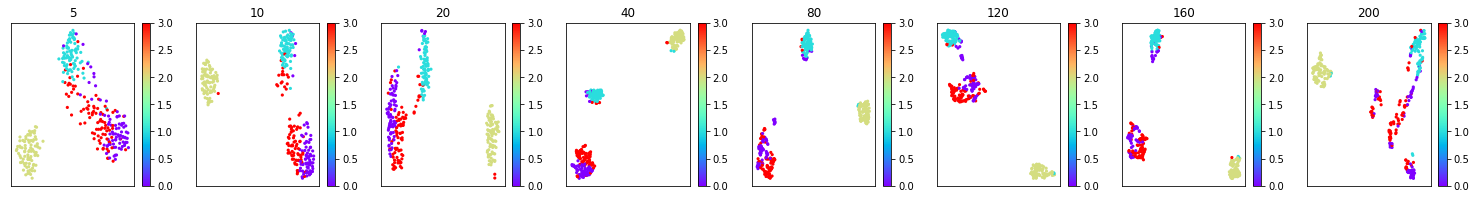

In [4]:
fig,axs = plt.subplots(1,len(ks))
fig.set_size_inches((26,3))
for i in range(len(ks)):
    ax = sam.scatter(projection = umaps[i] , axes = axs[i], c = 'kmeans_clusters')
    axs[i].set_title(ks[i])
    axs[i].set_xticks([]);
    axs[i].set_yticks([])

It seems that the results are quite robust to a wide range of values for `k`. We start doing poorly once `k` becomes too small or too big ($\leq 10$ or $ > 160$). Empirically, I have never needed to change this parameter from its default value of $20$. 

## num_norm_avg

Naively, one way to compute the SAM weights would be to simply normalize the spatial dispersions to be between 0 and 1 (i.e. divide by the max). However, this can be problematic if the max spatial dispersion is much larger than all the other genes. There are many ways to avoid this issue. For example, you could pass the spatial dispersions to a nonlinear function (like a sigmoid or gaussian) prior to dividing by the maximum.

SAM's chosen strategy to avoid this issue is to divide the spatial dispersions by the average of the largest $N$ (num_norm_avg) spatial dispersions instead of the maximum. Any weights bigger than $1$ after this operation are saturated to be $1$. Here's what the SAM weights look like for increasing values of $N$:

In [5]:
nna = [1,5,10,25,50,100,150,200,800]
umaps=[]
weights=[]
sds=[]
for n in nna:
    sam.run(num_norm_avg=n,verbose=False)
    xumap = sam.adata.obsm['X_umap']
    umaps.append(xumap)
    weights.append( np.array(sam.adata.var['weights']) )
    sds.append( np.array(sam.adata.var['spatial_dispersions']) )

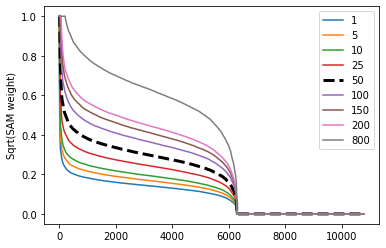

In [6]:
fig,axs = plt.subplots(1,1)
for i in range(len(nna)):
    if nna[i] == 50:
        axs.plot(-np.sort(-weights[i]), label = nna[i], linewidth = 3, color='black', linestyle='--')
    else:
        axs.plot(-np.sort(-weights[i]), label = nna[i])

axs.legend()
axs.set_ylabel('Sqrt(SAM weight)');

The weights are all sorted in decreasing order. The dotted black line is the default value of $N$ used by SAM. $N=1$ is equivalent to dividing by the maximum. As $N$ gets bigger, more genes receive larger weights.

What happens to the manifolds if more genes receive larger weights ($N>50$)? Or if more genes receive smaller weights ($N<50$)?

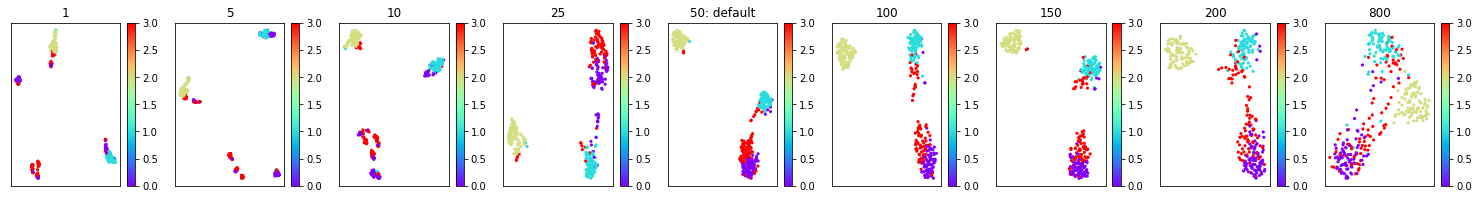

In [7]:
fig,axs = plt.subplots(1,len(nna))
fig.set_size_inches((26,3))
for i in range(len(nna)):
    ax = sam.scatter(projection = umaps[i] , axes = axs[i], c = 'kmeans_clusters')
    axs[i].set_title(nna[i])
    axs[i].set_xticks([]);
    axs[i].set_yticks([])
axs[4].set_title('50: default');

As $N$ gets smaller, the manifolds become 'tighter', perhaps even a bit overclustered, because fewer genes have large weights -- this is analgous to reducing the number of genes we are passing into PCA (and this tends to produce tighter & more clusters in low-dimensional embeddings). 

The opposite is true as $N$ gets bigger. Giving more genes large weights corresponds to less feature selection. For example, if $N=m$ where $m$ is the number of genes in our dataset, all genes would have a weight of $1$ and we would not be doing any feature selection (and thus including all the noisy / unimportant genes we would have otherwise downweighted). 



In the case of the schistosome dataset used here, the resulting manifold does seem to be quite dependent on the `num_norm_avg` parameter, especially for $N\leq 15$. However, note that in the schisto dataset, there are an especially small number of genes with relatively large spatial dispersions (~15 genes, not shown). In these cases, changing $N$ has a large effect. Notice that once $N$ is greater than $15$ the manifold seems to stabilize until $N$ gets too big. This is because the huge spatial dispersions from the top 15 genes start getting averaged out, allowing more genes to receive larger weights. 

In the SAM paper, I show that the number of genes with relatively huge spatial dispersions is inversely proportional to the 'complexity' of the dataset. In other words, datasets that are more difficult to analyze tend to have fewer genes with high spatial dispersion and vice-versa. Of the 56 datasets analyzed in the paper, the schisto dataset had the *highest* 'complexity' and the lowest number of genes with large dispersions. 

For this particular dataset, `num_norm_avg` is an important parameter: if it's too low, then our weights will get skewed by the few genes with large dispersions, and we will soft-select too few features, which might result in severe overclustering (although it is still unclear if these 'overclustered' clusters have no biological significance).

Here is an example of a dataset that has low 'complexity'. This dataset (by Darmanis et al., see the SAM paper for the reference) is a 'gold-standard' dataset that is often used for benchmarking clustering algorithms, and it has much lower 'complexity' than the schisto data (not shown here). We vary `num_norm_avg` as before:

In [8]:
sam2=SAM()
sam2.load_data('../../example_data/darmanis_data.csv.gz')
sam2.load_obs_annotations('../../example_data/darmanis_ann.csv')
sam2.preprocess_data()

nna = [1,5,10,25,50,100,150,200,800]
umaps=[]
weights=[]
sds=[]
for n in nna:
    sam2.run(num_norm_avg=n,verbose=False)
    xumap = sam2.adata.obsm['X_umap']
    umaps.append(xumap)
    weights.append( np.array(sam2.adata.var['weights']) )
    sds.append( np.array(sam2.adata.var['spatial_dispersions']) )

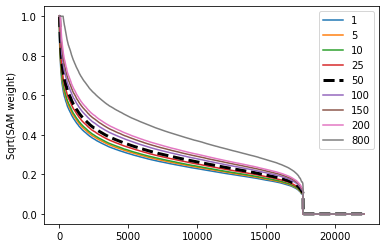

In [9]:
fig,axs = plt.subplots(1,1)
for i in range(len(nna)):
    if nna[i] == 50:
        axs.plot(-np.sort(-weights[i]), label = nna[i], linewidth = 3, color='black', linestyle='--')
    else:
        axs.plot(-np.sort(-weights[i]), label = nna[i])

axs.legend()
axs.set_ylabel('Sqrt(SAM weight)');

If we look at the distribution of SAM weights as we vary `num_norm_avg` ($N$), we see that there is much less change between the resulting weight distributions than we saw for the schistosome data.

Similarly, the corresponding manifolds are also visually indistinguishable. Thus, for this particular dataset, `num_norm_avg` is not an important parameter.

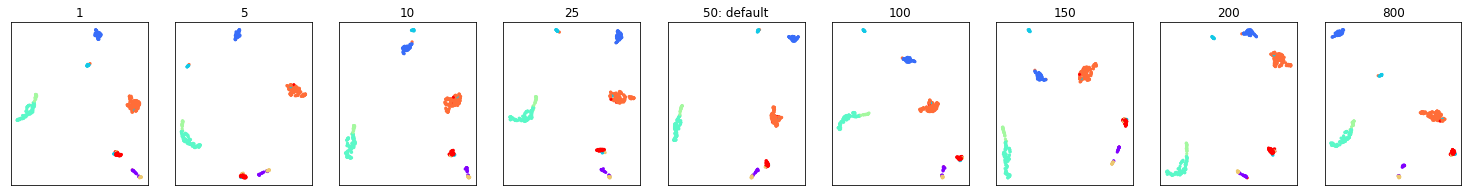

In [10]:
fig,axs = plt.subplots(1,len(nna))
fig.set_size_inches((26,3))
for i in range(len(nna)):
    ax = sam2.scatter(projection = umaps[i] , axes = axs[i], c = '0', colorbar=False)
    axs[i].set_title(nna[i])
    axs[i].set_xticks([]);
    axs[i].set_yticks([])
axs[4].set_title('50: default');

**What's the takeaway?**

For the most part, I leave `num_norm_avg` to be its default value of $50$, and this is the value I used for all the benchmarking in the paper. Setting $N=50$ does not affect the datasets that are robust to this parameter and, for datasets that are not robust to this parameter, ensures that we do not skew the distribution of weights by a small number of genes with exceptionally high spatial dispersions. 

Although unlikely, what if you have a large number of outlier genes (e.g. $50$) with relatively huge dispersions?  Setting `num_norm_avg=50`, the distribution of weights will still be skewed by the outliers (since the 50 outlier gene dispersions will just be averaged with each other). In this case, I would simply increase `num_norm_avg` (e.g. `num_norm_avg=100`).

## preprocessing

Prior to PCA, we either standardize the gene expression matrix  to have zero mean and unit variance per gene (which corrects for differences in distributions between genes) or normalize the expressions such that each cell has unit Euclidean (L2) norm (which prevents cells with large variances in gene expressions from dominating downstream analyses) prior to dimensionality reduction. 

Empirically, we have found that standardization performs well with large, sparse datasets with many subpopulations, whereas L2-normalization is more suitable for smaller datasets with fewer subpopulations. This is likely due to the fact that standardization amplifies the relative magnitude of expression of genes specific to small populations in large datasets, thereby making them easier to identify. In contrast, standardization decreases the relative expression of genes specific to populations comprising larger fractions of the data, as is typically the case in smaller datasets, thereby making distinct populations more difficult to identify.

For reference, Seurat always *standardizes* the data prior to PCA.

`preprocessing` can be either 'Normalizer' or 'StandardScaler' or None for normalization/standardization/no preprocessing, respectively:

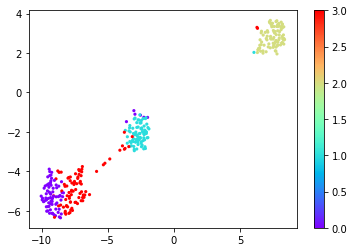

In [11]:
sam.run(preprocessing='Normalizer',verbose=False)
sam.scatter(c='kmeans_clusters')

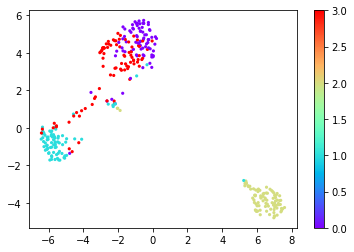

In [12]:
sam.run(preprocessing='StandardScaler',verbose=False)
sam.scatter(c='kmeans_clusters')

The schistosome dataset is a relatively small dataset with few subpopulations. Applied to this dataset, standardization seems to be worse at separating the populations.

Here's an example of normalization vs. standardization on a much bigger, sparser dataset (the planarian cell atlas from Fincher et al. 2018, Science):

In [13]:
sam3=SAM()
sam3.load_data('../../planarian_raw/pl_raw.h5ad')
sam3.preprocess_data(sum_norm='cell_median')
sam3.run(preprocessing='StandardScaler')

RUNNING SAM
Iteration: 0, Convergence: 0.4327508763355127
Iteration: 1, Convergence: 0.2802808943154974
Iteration: 2, Convergence: 0.008244938168144856
Computing the UMAP embedding...
Elapsed time: 271.1974518299103 seconds


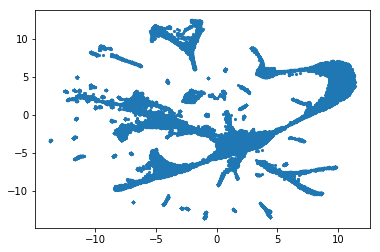

In [14]:
sam3.scatter();

In [15]:
sam3.run(preprocessing='Normalizer')

RUNNING SAM
Iteration: 0, Convergence: 0.43613739910526067
Iteration: 1, Convergence: 0.285458532833534
Iteration: 2, Convergence: 0.006741921409530135
Computing the UMAP embedding...
Elapsed time: 251.19977807998657 seconds


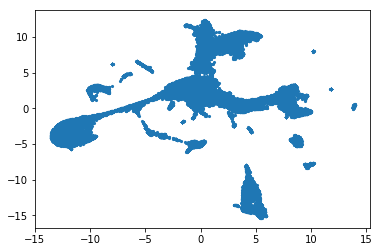

In [16]:
sam3.scatter()

For this large atlas dataset with many small subpopulations, preprocessing with standardization finds more small subpopulations than preprocessing with normalization. 

Here's a simple numerical example: Let's say one small population of 20 cells (out of 50,000) expresses a set of marker genes with $4$ expression units and these genes have zero expression everywhere else. If we standardize the gene expression, then the expression value of these marker genes gets amplified to 50. This is a much stronger signal.

In [21]:
a = np.zeros(50000)
a[:20]=4
a_std = (a-a.mean())/a.std()
print(a_std[0])

49.989998999799965


What if we have a subpopulation comprising a large fraction of the data, let's say 300 cells out of 1000, that expresses a set of marker genes with $4$ expression units? The expression value of these marker genes gets reduced to $1.5$ units after standardization. This is a weaker signal & thus this subpopulation might be harder to identify.

In [22]:
a = np.zeros(1000)
a[:300]=4
a_std = (a-a.mean())/a.std()
print(a_std[0])

1.5275252316519465


These examples are dramatic oversimplifications, but they illustrate our intuition for when we decide to use standardization vs normalization.

**What's the takeaway?**

A rough guideline:

If the subpopulations are expected to comprise relatively large fractions of the data (as is often the case for small datasets), then I use `preprocessing='Normalizer'`. If there are a large number of expected subpopulations (which is often the case for large datasets), then I use `preprocessing='StandardScaler'`.